In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

In [ ]:

import os
import re
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import ast

DATA_PATH = Path('/content/drive/MyDrive/Colab Notebooks/train_standardized.csv')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
df = pd.read_csv(DATA_PATH, sep=',')

In [ ]:

import json
json_file_path = '/content/drive/MyDrive/Colab Notebooks/unified_skills_mappings.json'
try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        skills_data = json.load(f)
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути '{json_file_path}'")
    skills_data = {}

SKILL_MAP_FROM_JSON = {}

for original_skill, details in skills_data.items():
    key = original_skill.lower()

    value = details.get('unified_skill', original_skill).lower()

    SKILL_MAP_FROM_JSON[key] = value

print(f"Загружено и обработано {len(SKILL_MAP_FROM_JSON)} правил из JSON.")
for i, (k, v) in enumerate(SKILL_MAP_FROM_JSON.items()):
    if i >= 5: break
    print(f"'{k}'  ->  '{v}'")




Загружено и обработано 2487 правил из JSON.
'1c document management'  ->  'работа с системами управления документами 1с'
'1c erp'  ->  'владение системой 1с:erp'
'1c software proficiency'  ->  'владение программным обеспечением 1с'
'1c упп'  ->  'работа с программным обеспечением 1с: управление производственным предприятием'
'1c: accounting'  ->  'владение программным обеспечением 1с: бухгалтерия'


In [ ]:
MANUAL_SKILL_MAP = {
    # Ключ (что ищем) -> Значение (на что меняем)

    # --- Группа "Налоговый учет" ---
    'знание налогового учета': 'налоговый учет',
    'ведение налогового учета': 'налоговый учет',

    # --- Группа "ПК" ---
    'владение компьютерная техника/оборудование': 'навыки работы с пк',
    'владение/пользователь пк': 'навыки работы с пк',
    'знание компьютерных и прочих программ': 'навыки работы с пк',
    'навыки работы с персональным компьютером': 'навыки работы с пк',

    # --- Группа "Зарплата" ---
    'расчет и начисление заработной платы': 'расчет заработной платы',

    # --- Группа "Первичка" ---
    'ведение первичной документации': 'работа с первичной документацией',
    'обработка первичной документации': 'работа с первичной документацией',
    'первичная бухгалтерия': 'работа с первичной документацией',

    # --- Группа "Бух. учет" ---
    'знание бухгалтерского учета': 'бухгалтерский учет',
    'ведение бухгалтерского учета': 'бухгалтерский учет',
    'организация бухгалтерского учета': 'бухгалтерский учет',
    'опыт работы бухгалтером': 'бухгалтерский учет', # Можно и так обобщить

    # --- Группа "ТМЦ" ---
    'анализ тмц': 'учет тмц',
    'движение/перемещение тмц': 'учет тмц',
    'инвентаризация тмц': 'учет тмц',
    'комплектация тмц': 'учет тмц',

    # --- Группа "НМА" ---
    'амортизация нма': 'учет нма',
    'инвентаризация нма': 'учет нма',

    # --- Группа "Затраты" ---
    'анализ затрат': 'управление затратами',
    'оптимизация затрат': 'управление затратами',
    'нормирование затрат': 'управление затратами',
    'планирование затрат': 'управление затратами',

    # --- Упрощение неопределенных сокращений ---
    'зна': 'знания', # Или можно просто удалить, если это мусор
    'компь': 'навыки работы с пк',
    'бух': 'бухгалтерия',

}

In [ ]:
def normalize_skill(text: str) -> str:
    s = str(text).lower().strip()

    s = re.sub(r'1[сc]', '1c', s)

    s = re.sub(r'\s+', ' ', s)
    s = s.strip(' "\'«».,;:|')

    if s in SKILL_MAP_FROM_JSON:
        s = SKILL_MAP_FROM_JSON[s]
    elif s in MANUAL_SKILL_MAP:
        s = MANUAL_SKILL_MAP[s]
    return s
def to_list_safe(x):
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s in ("", "[]", "{}", "nan", "None"):
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except Exception:
        return re.split(r'[;\n\r|]+', s)


def explode_item(item: str):
    text = str(item)

    text = re.sub(r'на основе\s*esco\s*taxonomy:.*', '', text, flags=re.IGNORECASE)

    text = re.sub(r'\s+[—\-–]\s+', ' | ', text)

    text = re.sub(r'\s+\d{1,2}[.)]\s+', ' | ', text)
    text = re.sub(r'^\s*\d{1,2}[.)]\s+', '', text)

    text = re.sub(r'[;\n\r]+', ' | ', text)

    text = re.sub(r'\s*\|\s*', ' | ', text)
    parts = [p.strip() for p in text.split(' | ') if p.strip()]
    return parts


def clean_and_parse_skills(row):
    skill_source_columns = [
        'skills_vacancy', 'hardSkills_vacancy', 'softSkills_vacancy',
        'standardize_skills_cv', 'combined_skills'
    ]
    raw_items = []
    for col in skill_source_columns:
        if col not in row.index:
            continue
        vals = row[col]
        seq = vals if isinstance(vals, list) else to_list_safe(vals)
        for it in seq:
            raw_items.extend(explode_item(it))

    skills = []
    for t in raw_items:
        t = normalize_skill(t)
        if not t:
            continue
        if len(t) < 2 or re.fullmatch(r'\d+', t):
            continue
        skills.append(t)

    return sorted(set(skills))

In [ ]:
df["salary"] = df[["salaryMin_vacancy", "salaryMax_vacancy"]].mean(axis=1, skipna=True)
df = df[df["salary"].notna() & (df["salary"] > 0)].copy()

df['skills_list_clean'] = df.apply(clean_and_parse_skills, axis=1)
print("\nТип первого элемента в skills_list_clean:", type(df['skills_list_clean'].iloc[0]))
display(df[['standardize_skills_cv', 'skills_list_clean']].head())



Тип первого элемента в skills_list_clean: <class 'list'>


,standardize_skills_cv,skills_list_clean
0,"['работа в команде', 'социальный интеллект']","[работа в команде, социальный интеллект]"
1,"['ведение документации', 'ведение кадровой док...","[ведение документации, ведение кадровой докуме..."
2,"['добросовестность', 'ответственность за выпол...","[обслуживание и ремонт электрооборудования, ор..."
3,['1. Соблюдение техники безопасности\n2. Соблю...,"[испытание электрооборудования, монтаж кабельн..."
4,[],[]


In [ ]:
def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom))

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def detect_target(df):
    candidates = ['salaryMin_vacancy', 'salary_rub', 'salary_from_rub', 'target']
    for c in candidates:
      print(c, df.columns)
      if c in df.columns:
        return c
    # fall back to last numeric
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise ValueError("No numeric columns found for target detection.")
    return num_cols[-1]

def detect_skills_col(df):
    candidates = ['skills', 'skills_list', 'competencies', 'combined_skills']
    for c in candidates:
        if c in df.columns.tolist():
            return c
    return None

def remove_skill_from_text(text, skill):
    if not isinstance(text, str):
        return text
    pattern = r'(?i)(?<!\w)' + re.escape(skill) + r'(?!\w)'
    return re.sub(pattern, ' ', text)

def add_skill_to_text(text, skill, sep=', '):
    text = '' if not isinstance(text, str) else text.strip()
    toks = [t.strip() for t in re.split(r'[;,]', text) if t.strip()]
    if skill not in toks:
        toks.append(skill)
    return sep.join(sorted(set(toks)))


In [ ]:
display(df.head(3))


,idCv,idVacancy,cv_status,locality,localityName,birthday,gender,age,positionName,dateCreate,...,addressCode,addressOffice,medicalDocument,benefit,conditions,combined_skills_cv,skills_len,standardize_skills_cv,salary,skills_list_clean
0,a4419ef0-93f4-11ec-a2fe-839f0d9a4379,72606f42-0c46-11ed-88f6-bf2cfe8c828d,Отказ,7.000900e+12,"Томская-область,-Колпашевский-район,-г-Колпашево",1997-08-25T00:00:00+0400,Мужской,27.0,Музыкальный-руководитель,2022-02-22T18:32:27+0300,...,7.000000e+12,NaN,NaN,NaN,NaN,"['Работа в команде', 'Социальный интеллект']",2,"['работа в команде', 'социальный интеллект']",45000.0,"[работа в команде, социальный интеллект]"
1,28438c80-77a8-11ed-bf5f-af80dfa0be97,0610f4d5-3667-11ee-a650-9586bb63c653,Отказ,5.900000e+12,"Пермский-край,-г-Пермь",1986-10-19T15:00:00+0300,Женский,38.0,Специалист-по-кадровому-делопроизводству,2022-12-09T12:59:23+0300,...,5.900000e+16,NaN,NaN,NaN,Оптимальные,"['делопроизводство', 'кадровое делопроизводств...",6,"['ведение документации', 'ведение кадровой док...",40561.0,"[ведение документации, ведение кадровой докуме..."
2,63c76610-4f7a-11ed-923c-457e0ebd778e,8ee52a15-6d05-11ec-b224-57fc951f3846,Приглашение,5.500000e+12,"Омская-область,-г-Омск",1992-01-08T00:00:00+0200,Женский,33.0,Администратор,2022-10-19T09:50:59+0300,...,5.500000e+16,NaN,NaN,NaN,Допустимые,"['добропорядочность', 'ответственность за дост...",3,"['добросовестность', 'ответственность за выпол...",48000.0,"[обслуживание и ремонт электрооборудования, ор..."


In [ ]:
df["salaryMin_vacancy"]

,salaryMin_vacancy
0,40000.0
1,36122.0
2,48000.0
3,42332.0
4,35000.0
...,...
150488,52000.0
150489,29172.0
150490,38000.0
150491,40000.0


In [ ]:
df.columns

Index(['idCv', 'idVacancy', 'cv_status', 'locality', 'localityName',
       'birthday', 'gender', 'age', 'positionName', 'dateCreate',
       'typicalPosition_cv', 'dateModify_cv', 'publishedDate',
       'academicDegree', 'skills_cv', 'driveLicenses', 'experience',
       'otherCertificates', 'country', 'educationList', 'hardSkills_cv',
       'softSkills_cv', 'workExperienceList', 'scheduleType_cv', 'salary_cv',
       'retrainingCapability_cv', 'businessTrip', 'languageKnowledge_cv',
       'relocation', 'innerInfo', 'salaryMin_cv', 'salaryMax_cv', 'education',
       'id_vacancy', 'stateRegionCode_vacancy', 'vacancyName',
       'codeProfession', 'codeProfessionalSphere', 'professionalSphereName',
       'vacancyAddress', 'vacancyAddressHouse', 'vacancyAddressAdditionalInfo',
       'geo', 'salary_vacancy', 'languageKnowledge_vacancy',
       'busyType_vacancy', 'educationRequirements', 'hardSkills_vacancy',
       'softSkills_vacancy', 'skills_vacancy', 'typicalPosition_vacancy',


In [ ]:
# 1. Регион (из localityName)
df['region'] = df['localityName'].fillna('Не указан')
print(f"Количество уникальных регионов: {df['region'].nunique()}")

# 2. Дата объявления (datePublished)
df['date_published'] = pd.to_datetime(df['datePublished'], errors='coerce')
df['year_published'] = df['date_published'].dt.year
df['month_published'] = df['date_published'].dt.month
df['day_of_week_published'] = df['date_published'].dt.dayofweek

# 3. Преобразование 'isQuoted' и 'isMobilityProgram' в числовой формат (0 или 1)
df['isQuoted'] = df['isQuoted'].fillna(False).astype(int)
df['isMobilityProgram'] = df['isMobilityProgram'].fillna(False).astype(int)

# 4. Apply Cat Codes to 'scheduleType_vacancy'
df['scheduleType_vacancy'] = df['scheduleType_vacancy'].astype('category').cat.codes
df['companyBusinessSize'] = df['companyBusinessSize'].astype('category').cat.codes
df['needMedcard'] = df['needMedcard'].astype('category').cat.codes

Количество уникальных регионов: 4785


/tmp/ipython-input-199787840.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isMobilityProgram'] = df['isMobilityProgram'].fillna(False).astype(int)


In [ ]:
df = df[df['skills_vacancy'].apply(lambda x: x != '[]' if pd.notna(x) else False)].copy()

def combine_skills(row):
    skills = []
    if pd.notna(row['skills_vacancy']) and row['skills_vacancy'] != '[]':
        skills.extend(eval(row['skills_vacancy']))
    if pd.notna(row['hardSkills_vacancy']) and row['hardSkills_vacancy'] != '[]':
        skills.extend(eval(row['hardSkills_vacancy']))
    if pd.notna(row['softSkills_vacancy']) and row['softSkills_vacancy'] != '[]':
        skills.extend(eval(row['softSkills_vacancy']))

    combined_skills = list(set([skill.lower() for skill in skills]))
    return combined_skills

df['combined_skills'] = df.apply(combine_skills, axis=1)

display(df[['skills_vacancy', 'hardSkills_vacancy', 'softSkills_vacancy', 'combined_skills']].head())

,skills_vacancy,hardSkills_vacancy,softSkills_vacancy,combined_skills
2,"[""Обслуживание и ремонт электрооборудования"", ...",[],[],[обслуживание и ремонт электрооборудования]
23,"[""Навыки работы с компьютерными офисными прогр...",[],[],[ведение бухгалтерского учета в бюджетной сфер...
26,"[""Организаторские способности"", ""Организация, ...",[],[],[работа с директором/руководителем: планирован...
55,"[""Внимательность"", ""Сборка/комплектация заказо...",[],[],"[внимательность, сборка/комплектация заказов]"
63,"[""Грамотность"", ""Пунктуальность"", ""Саморазвити...",[],[],"[грамотность, выполнение должностных, функцион..."


In [ ]:
vacancy_columns = [
    'vacancyName', 'experienceRequirements', 'scheduleType_vacancy', 'needMedcard',
    'requiredDriveLicense', 'companyBusinessSize', 'isQuoted', 'isMobilityProgram',
    'qualifications', 'responsibilities', 'year_published',
    'month_published', 'day_of_week_published', "professionalSphereName"
]

existing_core_cols = [col for col in vacancy_columns if col in df.columns]
X = df[existing_core_cols].copy()


print("Обработка и нормализация навыков...")
X['skills_list_clean'] = df.apply(clean_and_parse_skills, axis=1)
print("Готово.")



Обработка и нормализация навыков...
Готово.


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin

skills_col = 'skills_list_clean'
mlb = MultiLabelBinarizer(sparse_output=False)

skills_binarized = mlb.fit_transform(X[skills_col])
skills_df = pd.DataFrame(skills_binarized, columns=mlb.classes_, index=X.index)

X_base = X.drop(columns=[skills_col])
raw_skill_columns_to_drop = ['combined_skills', 'skills_vacancy', 'hardSkills_vacancy', 'softSkills_vacancy', 'standardize_skills_cv']
existing_raw_to_drop = [col for col in raw_skill_columns_to_drop if col in X_base.columns]
if existing_raw_to_drop:
    X_base = X_base.drop(columns=existing_raw_to_drop)
    print(f"Удалены сырые колонки с навыками: {existing_raw_to_drop}")


X_processed = pd.concat([X_base, skills_df], axis=1)

target_col = 'salary'
y = df[target_col].loc[X_processed.index]

print("\nФинальный DataFrame готов.")

print("\nФинальный DataFrame готов.")
if 'skills_list_clean' in X_processed.columns:
    print("ОШИБКА: Колонка 'skills_list_clean' все еще в данных!")
else:
    print("Проверка: Колонка 'skills_list_clean' успешно удалена.")

display(X_processed.head())



Финальный DataFrame готов.

Финальный DataFrame готов.
Проверка: Колонка 'skills_list_clean' успешно удалена.


,vacancyName,experienceRequirements,scheduleType_vacancy,needMedcard,requiredDriveLicense,companyBusinessSize,isQuoted,isMobilityProgram,qualifications,responsibilities,...,яндекс директ,яндекс метрика,яндекс метрика (ям) / yandex metrika,• владение компьютерной и другой оргтехники,"• коммуникабельность, стрессоустойчивость, внимательность к деталям",• опыт работы с людьми будет преимуществом,• работа со служебными документами,• соблюдение профессиональной этики,• соблюдение трудовой дисциплины,• уверенный пользователь пк
2,Электромонтер по ремонту и обслуживанию электр...,1.0,3,1,[],0,0,0,1. Опыт работы на промышленных предприятиях по...,"1. Обслуживание токарно-винторезных станков, л...",...,0,0,0,0,0,0,0,0,0,0
23,Ведущий специалист,3.0,1,1,[],4,0,0,Умение пользоваться компьютерными программами ...,"Ведение бухгалтерского и налогового учета, сос...",...,0,0,0,0,0,0,0,0,0,0
26,директор учреждения культуры,5.0,3,1,[],4,0,0,"Высшее образование, опыт работы на руководящей...",Действовать на основании устава Учреждения Обе...,...,0,0,0,0,0,0,0,0,0,0
55,Комплектовщик товара,0.0,3,1,[],0,0,0,Без опыта,Сборка и комплектовка товара с ТСД.,...,0,0,0,0,0,0,0,0,0,0
63,Главный инженер проекта,5.0,3,1,[],4,0,0,На должность главного инженера проекта назнача...,- анализ проектной документации; - контроль с...,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
target_col = 'salaryMax_vacancy'
y = df['salary'].loc[X_processed.index]
cat_cols = []
text_cols = []

base_feature_columns = [col for col in X_processed.columns if col not in mlb.classes_]

for c in base_feature_columns:
    if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):
        avg_tokens = X_processed[c].astype(str).str.split().map(len).mean()
        if avg_tokens is not None and avg_tokens > 10:
            text_cols.append(c)
        else:
            cat_cols.append(c)

print("Категориальные колонки:", cat_cols)
print("Текстовые колонки для TF-IDF:", text_cols)

# Log-transform
USE_LOG_TARGET = True
if USE_LOG_TARGET:
    y_transformed = np.log(np.maximum(y, 1.0))
else:
    y_transformed = y.copy()


/tmp/ipython-input-3875507492.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):
/tmp/ipython-input-3875507492.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):


Категориальные колонки: ['vacancyName', 'requiredDriveLicense', 'professionalSphereName']
Текстовые колонки для TF-IDF: ['qualifications', 'responsibilities']


/tmp/ipython-input-3875507492.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_processed[c]) or pd.api.types.is_categorical_dtype(X_processed[c]):


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_processed, y_transformed, test_size=0.2, random_state=RANDOM_STATE
)

In [ ]:
#X_train[skills_col].fillna("[]").astype(str).apply(clean_and_parse_skills)

In [ ]:

#from sklearn.preprocessing import MultiLabelBinarizer

# Убедимся, что колонка навыков - это список, а не строка
# Ваша функция parse_list отлично подходит
#X_train[skills_col] = X_train[skills_col].fillna("[]").astype(str).apply(clean_and_parse_skills)
#X_valid[skills_col] = X_valid[skills_col].fillna("[]").astype(str).apply(clean_and_parse_skills)

# Обучаем бинаризатор ТОЛЬКО на трейне
#mlb = MultiLabelBinarizer(sparse_output=False)
#X_train_skills = pd.DataFrame(
#    mlb.fit_transform(X_train[skills_col]),
#   index=X_train.index,
#    columns=mlb.classes_
#)

# Применяем на валидации
#X_valid_skills = pd.DataFrame(
#    mlb.transform(X_valid[skills_col]),
#    index=X_valid.index,
#   columns=mlb.classes_
#)

# Теперь у нас есть бинарные признаки для каждого навыка
#print(f"Создано {X_train_skills.shape[1]} бинарных признаков для навыков.")

# Соединяем их с основными данными, удаляя исходный столбец навыков
#X_train_processed = pd.concat([X_train.drop(columns=[skills_col]), X_train_skills], axis=1)
#X_valid_processed = pd.concat([X_valid.drop(columns=[skills_col]), X_valid_skills], axis=1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vecs = {}
X_train_num = X_train.copy()
X_valid_num = X_valid.copy()

for col in text_cols:
    vec = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=5)
    Xt = vec.fit_transform(X_train[col].fillna(""))
    Xv = vec.transform(X_valid[col].fillna(""))

    tf_cols = [f"{col}__tfidf_{i}" for i in range(Xt.shape[1])]
    X_train_tfidf = pd.DataFrame(Xt.toarray(), index=X_train.index, columns=tf_cols)
    X_valid_tfidf = pd.DataFrame(Xv.toarray(), index=X_valid.index, columns=tf_cols)

    X_train_num = pd.concat([X_train_num.drop(columns=[col]), X_train_tfidf], axis=1)
    X_valid_num = pd.concat([X_valid_num.drop(columns=[col]), X_valid_tfidf], axis=1)
    tfidf_vecs[col] = vec

duplicates = X_train_num.columns[X_train_num.columns.duplicated()]
if not duplicates.empty:
    print("Найдены дублирующиеся колонки:")
    print(duplicates.unique().tolist())
    print("\nПодсчет всех дубликатов:")
    print(X_train_num.columns.value_counts()[X_train_num.columns.value_counts() > 1])
else:
    print("Дублирующихся колонок не найдено.")

Дублирующихся колонок не найдено.


In [ ]:
new_cat_cols = [c for c in cat_cols if c in X_train_num.columns]
new_text_cols = []
new_num_cols  = [c for c in X_train_num.columns if c not in new_cat_cols]

def make_pool_num(X_df, y_vec=None):
    feature_names = list(X_df.columns)
    cat_idxs = [feature_names.index(c) for c in new_cat_cols if c in feature_names]
    return Pool(
        data=X_df,
        label=y_vec,
        cat_features=cat_idxs if cat_idxs else None,
        feature_names=feature_names,
    )

train_pool_num = make_pool_num(X_train_num, y_train)
valid_pool_num = make_pool_num(X_valid_num, y_valid)

from catboost.utils import get_gpu_device_count
gpu_ok = (get_gpu_device_count() > 0)

params = dict(
    loss_function='RMSE',
    depth=8,
    iterations=1200,
    learning_rate=0.045,
    random_seed=RANDOM_STATE,
    od_type='Iter',
    od_wait=50,
    verbose=100,
    task_type='GPU' if gpu_ok else 'CPU'
)

model = CatBoostRegressor(**params)
print(y_train)
model.fit(train_pool_num, eval_set=valid_pool_num)

yhat_valid_t = model.predict(valid_pool_num)
yhat_valid = np.exp(yhat_valid_t) if USE_LOG_TARGET else yhat_valid_t
y_valid_orig = np.exp(y_valid) if USE_LOG_TARGET else y_valid

print("Validation RMSE:", rmse(y_valid_orig, yhat_valid))
print("Validation MAPE:", mape(y_valid_orig, yhat_valid))



72733     11.346871
131012    10.959540
94036     10.546380
121901    10.714418
11829     10.388995
            ...    
83433     10.032320
75292     10.768485
78301     10.546380
12264     11.608236
105934    10.341742
Name: salary, Length: 8268, dtype: float64
0:	learn: 0.4506362	test: 0.4501121	best: 0.4501121 (0)	total: 2s	remaining: 40m 2s
100:	learn: 0.2806320	test: 0.2830104	best: 0.2830104 (100)	total: 53.6s	remaining: 9m 43s
200:	learn: 0.2556554	test: 0.2651833	best: 0.2651833 (200)	total: 1m 38s	remaining: 8m 11s
300:	learn: 0.2339619	test: 0.2508614	best: 0.2508614 (300)	total: 2m 22s	remaining: 7m 5s
400:	learn: 0.2154252	test: 0.2408762	best: 0.2408762 (400)	total: 3m 7s	remaining: 6m 12s
500:	learn: 0.2003995	test: 0.2327619	best: 0.2327619 (500)	total: 3m 51s	remaining: 5m 23s
600:	learn: 0.1880323	test: 0.2267565	best: 0.2267565 (600)	total: 4m 35s	remaining: 4m 35s
700:	learn: 0.1772358	test: 0.2215896	best: 0.2215896 (700)	total: 5m 20s	remaining: 3m 48s
800:	learn: 

Validation RMSE: 15028.113634385627
Validation MAPE: 0.12907582168548976


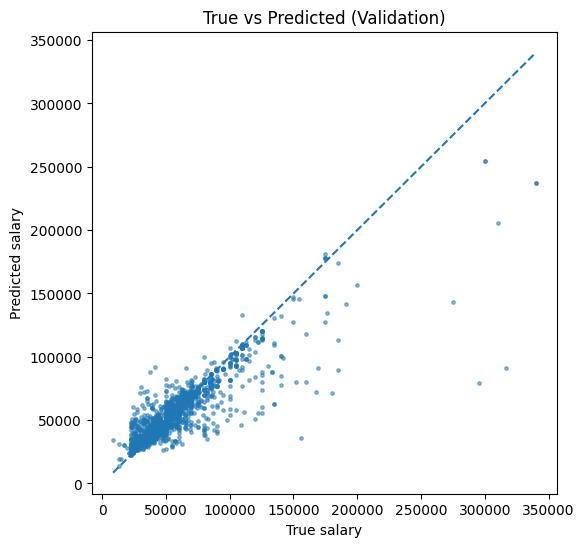

In [ ]:
def inv_transform(yhat):
    if USE_LOG_TARGET:
        return np.exp(yhat)
    return yhat

yhat_valid_t = model.predict(valid_pool_num)
yhat_valid = inv_transform(yhat_valid_t)
y_valid_orig = np.exp(y_valid) if USE_LOG_TARGET else y_valid


print("Validation RMSE:", rmse(y_valid_orig, yhat_valid))
print("Validation MAPE:", mape(y_valid_orig, yhat_valid))

plt.figure(figsize=(6,6))
plt.scatter(y_valid_orig, yhat_valid, s=6, alpha=0.5)
plt.xlabel("True salary")
plt.ylabel("Predicted salary")
plt.title("True vs Predicted (Validation)")
plt.plot([y_valid_orig.min(), y_valid_orig.max()],
         [y_valid_orig.min(), y_valid_orig.max()], linestyle='--')
plt.show()

In [ ]:
shap_vals = model.get_feature_importance(valid_pool_num, type='ShapValues')
feature_names = valid_pool_num.get_feature_names()

shap_main = shap_vals[:, :-1]
expected_vals = shap_vals[:, -1]

mean_abs_shap = np.abs(shap_main).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

shap_df.head(20)

,feature,mean_abs_shap
0,vacancyName,0.134595
1,experienceRequirements,0.064072
11,professionalSphereName,0.062824
7307,qualifications__tfidf_998,0.026318
7105,qualifications__tfidf_796,0.013045
5,companyBusinessSize,0.012191
2,scheduleType_vacancy,0.011565
7313,qualifications__tfidf_1004,0.009260
6556,qualifications__tfidf_247,0.008634
7490,qualifications__tfidf_1181,0.007981


In [ ]:
def predict_salary_processed(df_processed):
    model_features = train_pool_num.get_feature_names()
    df_processed = df_processed[model_features]
    pool = make_pool_num(df_processed, None)
    yhat_t = model.predict(pool)
    return inv_transform(yhat_t)

def skill_value_for_row_binarized(row_idx, skill_name, X_processed_df):
    if skill_name not in X_processed_df.columns:
        return None, f"Навык '{skill_name}' не найден в колонках датафрейма. Возможно, он редкий и был отфильтрован."

    x_base = X_processed_df.iloc[[row_idx]].copy()
    base_pred = float(predict_salary_processed(x_base)[0])

    x_minus = x_base.copy()
    x_minus.loc[:, skill_name] = 0
    minus_pred = float(predict_salary_processed(x_minus)[0])

    x_plus = x_base.copy()
    x_plus.loc[:, skill_name] = 1
    plus_pred = float(predict_salary_processed(x_plus)[0])

    value = plus_pred - minus_pred
    delta_plus = plus_pred - base_pred
    delta_minus = base_pred - minus_pred

    return {
        'row_idx': row_idx,
        'skill': skill_name,
        'skill_was_present': bool(x_base[skill_name].iloc[0] == 1),
        'y_base': base_pred,
        'y_minus': minus_pred,
        'y_plus': plus_pred,
        'value_plus_minus': value,
        'delta_plus_vs_base': delta_plus,
        'delta_minus_vs_base': delta_minus
    }, None




In [ ]:
mlb.classes_

array(['**identify skills**: determine which items in the list are actual skills or competencies. this may require some judgment or additional research',
       '**list the standardized skills**: once you have identified the esco terms, list them',
       '**map to esco**: use the esco (european skills, competences, qualifications and occupations) database to find the standardized terms for each skill. you can access the esco portal online to search for each skill',
       ..., '• соблюдение профессиональной этики',
       '• соблюдение трудовой дисциплины', '• уверенный пользователь пк'],
      dtype=object)

In [ ]:
import numpy as np

def skills_in_model():
    mf = set(train_pool_num.get_feature_names())
    return [s for s in mlb.classes_ if s in mf]

def avg_pred_salary(X_df):
    return float(np.mean(predict_salary_processed(X_df)))

BASE_MEAN = avg_pred_salary(X_valid_num)

def avg_uplift_for_skill_missing_only(skill, X_df, sample=1500):
    if skill not in X_df.columns or skill not in train_pool_num.get_feature_names():
        return None
    Xs = X_df[X_df[skill] == 0]
    if len(Xs) == 0:
        return None
    if sample and len(Xs) > sample:
        Xs = Xs.sample(sample, random_state=RANDOM_STATE)
    X_plus = Xs.copy(); X_plus.loc[:, skill] = 1
    uplift = predict_salary_processed(X_plus) - predict_salary_processed(Xs)
    return float(np.mean(uplift)), float(np.median(uplift))

def find_top_addable_skills(X_df, topn=20):
    res = []
    for s in skills_in_model():
        r = avg_uplift_for_skill_missing_only(s, X_df)
        if r is None:
            continue
        mean_up, med_up = r
        res.append((s, mean_up, med_up, mean_up / BASE_MEAN * 100.0))
    res.sort(key=lambda t: t[1], reverse=True)
    return res[:topn]

top_addable = find_top_addable_skills(X_valid_num, topn=20)
for s, mean_up, med_up, pct in top_addable:
    print(f"{s:60s} +{mean_up:,.0f} руб. (медиана {med_up:,.0f}), {pct:.2f}%")

KeyboardInterrupt: 

In [ ]:
def top_addable_skills_for_row(row_idx, topn=10):
    skills = [s for s in mlb.classes_ if s in train_pool_num.get_feature_names()]
    x = X_valid_num.iloc[[row_idx]].copy()
    base = float(predict_salary_processed(x)[0])
    gains = []
    for s in skills:
        if s in x.columns and x.at[x.index[0], s] == 0:
            x1 = x.copy(); x1.loc[:, s] = 1
            plus = float(predict_salary_processed(x1)[0])
            gains.append((s, plus - base, (plus - base)/base*100))
    gains.sort(key=lambda t: t[1], reverse=True)
    return gains[:topn]

best_for_row = top_addable_skills_for_row(20, topn=10)
for k, v, pct in best_for_row:
    print(f"{k:60s} +{v:,.0f} руб. ({pct:.2f}%)")

In [ ]:
skill_names = mlb.classes_

skill_shap_df = shap_df[shap_df['feature'].isin(skill_names)].copy()

skill_shap_df['frequency'] = skill_shap_df['feature'].apply(lambda x: X_train_num[x].sum())

skill_shap_df_filtered = skill_shap_df[skill_shap_df['frequency'] >= 10]


print("--- Топ-20 самых ВАЖНЫХ (влиятельных) навыков по мнению модели ---")
display(skill_shap_df_filtered.sort_values('mean_abs_shap', ascending=False).head(20))

In [ ]:
def get_average_skill_value(skill_name, X_processed_df):
    if skill_name not in X_processed_df.columns:
        print(f"Навык '{skill_name}' не найден.")
        return None

    df_minus = X_processed_df.copy()
    df_plus = X_processed_df.copy()

    df_minus[skill_name] = 0
    df_plus[skill_name] = 1

    print(f"Получение предсказаний для '{skill_name}'...")
    preds_minus = predict_salary_processed(df_minus)
    preds_plus = predict_salary_processed(df_plus)

    avg_value = np.mean(preds_plus - preds_minus)
    return avg_value

avg_cost_pc = get_average_skill_value('навыки работы с компьютером', X_valid_num)
print(f"Средняя стоимость навыка 'навыки работы с компьютером': {avg_cost_pc} руб.")

avg_cost_sql = get_average_skill_value('планирование экономической, финансово-хозяйственной деятельности компании', X_valid_num) # Замените на реальный навык из ваших данных
print(f"Средняя стоимость навыка 'формирование и сдача отчетности по заработной плате': {avg_cost_sql} руб.")

In [ ]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error

def _split_cat_text_cols(X_df, skill_cols):
    base_cols = [c for c in X_df.columns if c not in skill_cols]
    cat_cols, text_cols = [], []
    for c in base_cols:
        if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
            avg_tokens = X_df[c].astype(str).str.split().map(len).mean()
            if avg_tokens and avg_tokens > 10:
                text_cols.append(c)
            else:
                cat_cols.append(c)
    return cat_cols, text_cols

def _coerce_lists_to_str(df_in):
    df = df_in.copy()
    bad = [c for c in df.columns if df[c].apply(lambda v: isinstance(v, (list, tuple, set, dict))).any()]
    if bad:
        for c in bad:
            df[c] = df[c].apply(
                lambda v: ' | '.join(map(str, v)) if isinstance(v, (list, tuple, set))
                else (json.dumps(v, ensure_ascii=False) if isinstance(v, dict) else v)
            )
    return df

def _make_pool_with_cats(X_df, y_vec, cat_cols):
    feature_names = list(X_df.columns)
    cat_idxs = [feature_names.index(c) for c in cat_cols if c in feature_names]
    return Pool(
        data=X_df,
        label=y_vec,
        cat_features=cat_idxs if cat_idxs else None,
        feature_names=feature_names,
    )

def kfold_experiment_processed(X_df, y_vec, skill_cols, n_splits=5,
                               tfidf_max_features=800, tfidf_min_df=10, tfidf_ngram=(1,2)):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    rmses, maes, mapes = [], [], []

    for i, (tr, va) in enumerate(kf.split(X_df), 1):
        trX_raw, vaX_raw = X_df.iloc[tr].copy(), X_df.iloc[va].copy()
        trY, vaY = y_vec.iloc[tr].copy(), y_vec.iloc[va].copy()

        cat_cols, text_cols = _split_cat_text_cols(trX_raw, skill_cols)

        trX, vaX = trX_raw.copy(), vaX_raw.copy()
        for col in text_cols:
            vec = TfidfVectorizer(max_features=tfidf_max_features,
                                  ngram_range=tfidf_ngram, min_df=tfidf_min_df)
            Xt = vec.fit_transform(trX[col].fillna(""))
            Xv = vec.transform(vaX[col].fillna(""))

            tf_cols = [f"{col}__tfidf_{j}" for j in range(Xt.shape[1])]
            trX_tfidf = pd.DataFrame(Xt.toarray(), index=trX.index, columns=tf_cols)
            vaX_tfidf = pd.DataFrame(Xv.toarray(), index=vaX.index, columns=tf_cols)

            trX = pd.concat([trX.drop(columns=[col]), trX_tfidf], axis=1)
            vaX = pd.concat([vaX.drop(columns=[col]), vaX_tfidf], axis=1)

        trX = _coerce_lists_to_str(trX)
        vaX = _coerce_lists_to_str(vaX)

        tr_pool = _make_pool_with_cats(trX, trY, cat_cols)
        va_pool = _make_pool_with_cats(vaX, vaY, cat_cols)

        model_cv = CatBoostRegressor(**params)
        model_cv.fit(tr_pool, eval_set=va_pool, verbose=False)

        yhat_t = model_cv.predict(va_pool)
        yhat = inv_transform(yhat_t)
        y_true = inv_transform(vaY)

        rmses.append(rmse(y_true, yhat))
        maes.append(mean_absolute_error(y_true, yhat))
        mapes.append(mape(y_true, yhat))

        print(f"Fold {i}: RMSE={rmses[-1]:,.0f} | MAE={maes[-1]:,.0f} | MAPE={mapes[-1]:.4f}")

    print("KFold RMSE mean±std:", f"{np.mean(rmses):,.0f}", f"± {np.std(rmses):,.0f}")
    print("KFold MAE  mean±std:", f"{np.mean(maes):,.0f}",  f"± {np.std(maes):,.0f}")
    print("KFold MAPE mean±std:", f"{np.mean(mapes):.4f}",   f"± {np.std(mapes):.4f}")

In [ ]:
# skill_cols = skills_df_use.columns.tolist()
kfold_experiment_processed(X_processed, y_transformed, mlb.classes_.tolist(), n_splits=5)

/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 1: RMSE=14,947 | MAE=6,934 | MAPE=0.1260


/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 2: RMSE=12,761 | MAE=6,387 | MAPE=0.1229


/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 3: RMSE=13,284 | MAE=6,949 | MAPE=0.1281


/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 4: RMSE=13,823 | MAE=6,586 | MAPE=0.1188


/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):
/tmp/ipython-input-3217214595.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(X_df[c]) or pd.api.types.is_categorical_dtype(X_df[c]):


Fold 5: RMSE=12,931 | MAE=6,560 | MAPE=0.1280
KFold RMSE mean±std: 13,549 ± 788
KFold MAE  mean±std: 6,683 ± 222
KFold MAPE mean±std: 0.1248 ± 0.0035


In [ ]:

from IPython.display import display
import pandas as pd
import numpy as np

print("Подготовка данных для сводной таблицы...")


if 'professionalSphereName' in X_valid.columns:
    specialty_col = 'professionalSphereName'
else:
    specialty_col = 'vacancyName'

results_df_catboost = pd.DataFrame({
    'true_mid': y_valid_orig,
    'pred_mid': yhat_valid,
    'specialty': X_valid[specialty_col].fillna('Не указана')
})


def calculate_metrics_catboost(data_subset):
    mae_point = np.mean(np.abs(data_subset['true_mid'] - data_subset['pred_mid']))
    return {'CatBoost (точечный)': mae_point}


report_data = []

unique_specialties = results_df_catboost['specialty'].unique()
specialties_in_report = []

for specialty in unique_specialties:
    specialty_subset = results_df_catboost[results_df_catboost['specialty'] == specialty]
    if len(specialty_subset) < 5:
        continue

    specialties_in_report.append(specialty)

    specialty_metrics = calculate_metrics_catboost(specialty_subset)
    specialty_metrics['Специальность'] = specialty
    report_data.append(specialty_metrics)

reportable_df = results_df_catboost[results_df_catboost['specialty'].isin(specialties_in_report)]

total_metrics = calculate_metrics_catboost(reportable_df)
total_metrics['Специальность'] = 'Полная матрица (показанные)'

report_data.insert(0, total_metrics)

report_df = pd.DataFrame(report_data).set_index('Специальность')
report_df['CatBoost (интервальный)'] = np.nan
column_order = ['CatBoost (точечный)', 'CatBoost (интервальный)']

total_row_df = report_df.head(1)
industry_rows_df = report_df.iloc[1:].sort_values(by='CatBoost (точечный)')
report_df_sorted = pd.concat([total_row_df, industry_rows_df])

print("\n" + "="*50)
print("Таблица — Результаты экспериментов (CatBoost - точечная модель)")
print("="*50)
display(report_df_sorted.style.format("{:,.1f}", na_rep="-"))


Подготовка данных для сводной таблицы...

Таблица — Результаты экспериментов (CatBoost - точечная модель)


,CatBoost (точечный),CatBoost (интервальный)
Специальность,,
Полная матрица (показанные),"7,026.2",-
Легкая промышленность,"2,818.8",-
"Государственная служба, некоммерческие организации","3,784.3",-
Юриспруденция,"3,847.3",-
Пищевая промышленность,"4,858.1",-
"Административная работа, секретариат, АХО","4,884.8",-
"Консалтинг, стратегическое развитие, управление","4,916.9",-
"Бухгалтерия, налоги, управленческий учет","5,389.6",-
"Работы, не требующие квалификации","5,542.4",-


In [ ]:
 """
# Save model and column schema for reuse
#MODEL_PATH = Path('/mnt/data/catboost_skill_model.cbm')
#SCHEMA_PATH = Path('/mnt/data/experiment_schema.json')

#model.save_model(str(MODEL_PATH))

#schema = {
#    "target_col": target_col,
#    "skills_col": skills_col,
#    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "text_cols": text_cols,
    "use_log_target": USE_LOG_TARGET,
    "random_state": RANDOM_STATE
}
with open(SCHEMA_PATH, 'w') as f:
    json.dump(schema, f, indent=2)

MODEL_PATH, SCHEMA_PATH
"""